## Analysis on helix structure to see if associated HLA peptides are more likely to be part of a helix or soluble domain compared to GWAS tested and the rest of the entire library

In [39]:
import os
import sys
import pickle as pkl
import pandas as pd
import numpy as np
import os
import sys
from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns
import gzip

In [ ]:
# Load the file containing the information on the peptides (obtained from the initial analysis)
df_peptides_classified = pd.read_csv('data/all_annotated_peptides_classified_reduced.csv')

In [ ]:
# Get the results from Topgraph analysis (prediction if membrane protein)
# First gunzip the dict file
dict_peptides_position_and_values = pd.read_pickle('data/dict_peptides_position_and_values.pkl')

In [35]:
# Check if in which area of the membrane proteins each peptide is located
def check_membrane_position(predicted_seq_vals):
    inner_membrane = 0
    transmembrane = 0
    external_membrane = 0
    for i in predicted_seq_vals:
        if i == 1:
            inner_membrane += 1
        elif i == 2:
            external_membrane += 1
        elif i == 'H':
            transmembrane += 1
    try:
        ratio_transmembrane= transmembrane/len(predicted_seq_vals)
    except:
        ratio_transmembrane=0

    
    if 'H' in predicted_seq_vals and ratio_transmembrane >= 0.1 and  ratio_transmembrane <= 0.8:
        return 'Partially transmembrane'
    elif 'H' in predicted_seq_vals and ratio_transmembrane > 0.8:
        return 'Transmembrane'
    else:
        return 'Soluble'


df_transmembrane_domains = pd.DataFrame({'peptide_name' : dict_peptides_position_and_values.keys(),
                                         'aa_seq' : [x[0] for x in dict_peptides_position_and_values.values()],
                                         'predicted_transmemb_motif_seq' : [x[1] for x in dict_peptides_position_and_values.values()],
                                         'whole_protein_prediction' : [x[2] for x in dict_peptides_position_and_values.values()],
                                         'prot_num' :  [x[3] for x in dict_peptides_position_and_values.values()]})
df_transmembrane_domains['transmembrane_type'] = df_transmembrane_domains['predicted_transmemb_motif_seq'].apply(lambda x: check_membrane_position(x))

In [36]:
# Merge the results of this to the initial table
final_df_merged = pd.merge(df_peptides_classified[['peptide_name', 'aa_seq', 'Type']], df_transmembrane_domains[['peptide_name', 'transmembrane_type']], on='peptide_name', how='outer')

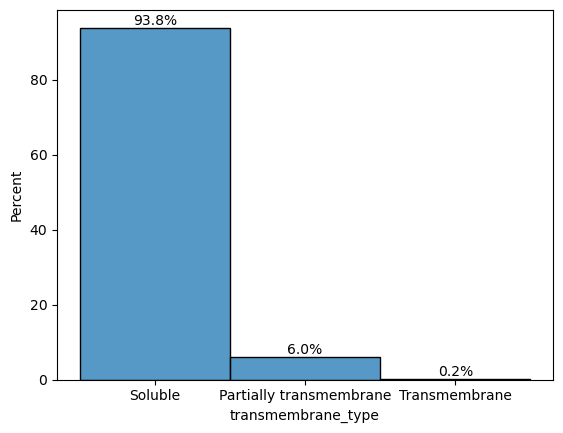

In [37]:
# Add statistical test: show in the other format also.
# Play on the cutoffs
ax = sns.histplot(data=final_df_merged, x='transmembrane_type', stat='percent')

# Add labels on top of bars
for p in ax.patches:
    height = p.get_height()  # Get the bar height
    if height > 0:  # Only label bars with data
        ax.annotate(f'{height:.1f}%',  
                    (p.get_x() + p.get_width() / 2., height),  
                    ha='center', va='bottom', fontsize=10, color='black')



Now plot the different percentage of peptides which are labelled as soluble / transmembrane 

Soluble
0    Entire library
1       GWAS tested
2    HLA associated
Name: Type, dtype: object
Entire library GWAS tested
226999
2.7476543776214957e-12
Entire library HLA associated
226999
0.00043450037082845756
GWAS tested HLA associated
1480
0.6854937683755599
Partially transmembrane
0    Entire library
1       GWAS tested
2    HLA associated
Name: Type, dtype: object
Entire library GWAS tested
14501
6.204051355183857e-13
Entire library HLA associated
14501
4.5258023796314026e-05
GWAS tested HLA associated
32
0.3819853784367428


/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_59024/1793374041.py:28: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(int(grouped_data[grouped_data['Type'].isin([type1])]['counts']))
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_59024/1793374041.py:29: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cont_table = [(int(grouped_data[grouped_data['Type'].isin([type1])]['counts']),
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_59024/1793374041.py:30: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(grouped_data[grouped_data['Type'].isin([type2])]['counts'])),
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_59024/1793374041.py:31: FutureWarning: Calling int o

Text(0.5, 1.0, 'Fraction of peptides\ninvolved in Helix structure')

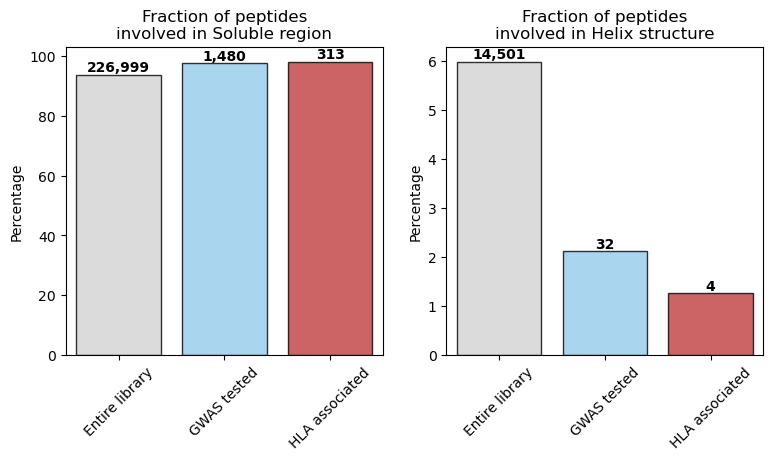

In [42]:
import itertools
import scipy.stats as stats

fig, axes = plt.subplots(1,2, figsize=(9,4))
colors = ['lightgrey', 'lightskyblue', 'tab:red']

dict_dataset_values = {'Entire library' : 242165, 'GWAS tested' : 1516, 'HLA associated' : 319}

for membrane_type,ax in zip(final_df_merged['transmembrane_type'].dropna().unique(), axes):
    print(membrane_type)
    #print(membrane_type)
    data=final_df_merged[final_df_merged['transmembrane_type'] == membrane_type]
    # print(data.columns)
    grouped_data = data.groupby(['transmembrane_type', 'Type']).count()[['peptide_name']].reset_index()
    grouped_data.columns = ['transmembrane_type', 'Type', 'counts']
    percentages = []
    try:
        for x,y in zip(grouped_data.counts, [242165, 1516, 319]):
            percentages.append(x/y*100)
        grouped_data['percentages'] = percentages
    except:
        print('no')
    print(grouped_data.loc[:,'Type'])
    # Pairwise Fisher's Exact Test
    pairwise_results = {}
    for type1, type2 in itertools.combinations(grouped_data['Type'], 2):
        print(type1, type2)
        print(int(grouped_data[grouped_data['Type'].isin([type1])]['counts']))
        cont_table = [(int(grouped_data[grouped_data['Type'].isin([type1])]['counts']),
          int(grouped_data[grouped_data['Type'].isin([type2])]['counts'])),
           (dict_dataset_values[type1] - int(grouped_data[grouped_data['Type'].isin([type1])]['counts']),
            dict_dataset_values[type2] - int(grouped_data[grouped_data['Type'].isin([type2])]['counts']))]
        # Fisher's exact test
        odds_ratio, p_value = stats.fisher_exact(cont_table)
        
        pairwise_results[f"{type1} vs {type2}"] = {"Odds Ratio": odds_ratio, "P-Value": p_value}
        print(p_value)

    # try:
    #     list(grouped_data['counts']) / [len(final_df_merged[final_df_merged['Type'] == 'Entire library']) , len(final_df_merged[final_df_merged['Type'] == 'GWAS tested']), len(final_df_merged[final_df_merged['Type'] == 'HLA associated'])]


    ax = sns.barplot(data=grouped_data, x='Type', y='percentages', palette=colors, alpha=.8, ax=ax, edgecolor='black')

    # Add count labels on top of each bar
    # Add count labels on top of each bar
    for p, count in zip(ax.patches, grouped_data['counts']):
        ax.annotate(f'{count:,}',  # Format counts with commas
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position on top of the bar
                    ha='center', va='bottom', 
                    fontsize=10, fontweight='bold', color='black')
    if membrane_type in final_df_merged['transmembrane_type'].unique()[1:]:
        ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel('Percentage')
    ax.set_xlabel('')
    ax.set_title('Fraction of peptides\ninvolved in Soluble region')
ax.set_title('Fraction of peptides\ninvolved in Helix structure')